In [1]:
state_reordered = [2,6,1,7,0,4,3,5]
# Re-ordered following this nomenclature:
# 1 - Higher-order anterior
# 2 - Higher-order posterior
# 3 - Unimodal visual
# 4 - Unimodal sensorimotor
# 5 - DMN-Visual Ventral
# 6 - DMN-Visual Dorsal
# 7 - Lateralized Left
# 8 - Interhemispheric Visual

brain_states_dict = {
    1: "Higher-order Anterior",
    2: "Higher-order Posterior",
    3: "Unimodal Visual",
    4: "Unimodal Sensorimotor",
    5: "DMN-Visual Ventral",
    6: "DMN-Visual Dorsal",
    7: "Lateralized Language",
    8: "Lateralized Right"
    }

In [42]:
n_states = 8

import os
import numpy as np
import matplotlib.pyplot as plt
from osl_dynamics.analysis import power, connectivity
from osl_dynamics.utils import plotting

# Directories
BASE_DIR = "E:/Research_Projects/MEG_CamCAN"
spectra_dir = f"{BASE_DIR}/TDE_HMM/results/inf_params/{n_states:02d}_states"
networks_dir = f"{BASE_DIR}/TDE_HMM/results/{n_states:02d}_states_networks"

os.makedirs(networks_dir, exist_ok=True)

# Source reconstruction files
mask_file = "MNI152_T1_8mm_brain.nii.gz"
parcellation_file = "Glasser52_binary_space-MNI152NLin6_res-8x8x8.nii.gz"

f = np.load(f"{spectra_dir}/f.npy")  # (n_freq,)
psd = np.load(f"{spectra_dir}/psd.npy")[:,state_reordered,...]  # (n_subjects, n_states, n_parcels, n_freq)
coh = np.load(f"{spectra_dir}/coh.npy")[:,state_reordered,...]  # (n_subjects, n_states, n_parcels, n_parcels, n_freq)
w = np.load(f"{spectra_dir}/w.npy")  # (n_subjects,)

# Import fractional occupancies to be used as weights
fo = np.load(f"{BASE_DIR}/TDE_HMM/results/inf_params/{n_states:02d}_states/fo.npy")
gfo = np.mean(fo, axis=0)[state_reordered]
np.save(f"{BASE_DIR}/TDE_HMM/results/inf_params/{n_states:02d}_states/gfo_ordered.npy", gfo)

print(f.shape)
print(psd.shape)
print(coh.shape)
print(w.shape)
print(gfo.shape)

(88,)
(621, 8, 52, 88)
(621, 8, 52, 52, 88)
(621,)
(8,)


Find state-relevant frequency ranges with NNMF

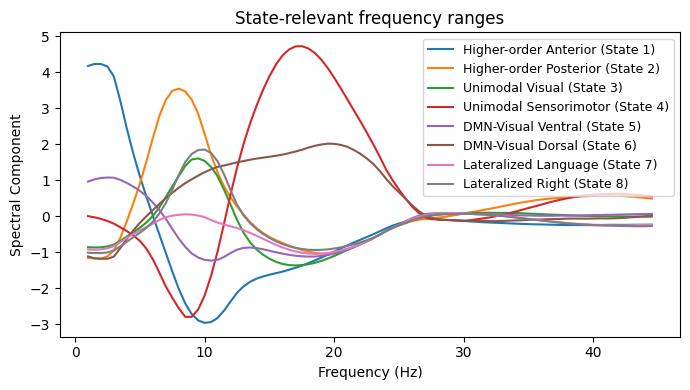

In [43]:
# from osl_dynamics.analysis import spectral

################
# NNMF -
# for state in range(8):
#     nnmf = spectral.decompose_spectra(coh[:,state,...], n_components=4)
#     np.save(f"{networks_dir}/nnmf_{state+1}.npy", nnmf)
################

################
# LOAD NNMF components
nnmf_state_list = []
for state in range(8): 
    nnmf_tmp = np.load(f"{networks_dir}/nnmf_{state+1}.npy")  
    nnmf_state_list.append(nnmf_tmp)
nnmf_state = np.stack(nnmf_state_list) # (n_states, n_components, n_freq)

# for state in range(8): 
# Visualize and match to the state-relevant PSD
#     plotting.plot_line(
#         [f,f,f,f],  # we need to repeat f times because we fitted f components
#         nnmf_state[state,...],
#         x_label="Frequency (Hz)",
#         y_label="Spectral Component",
#         labels=[f"Mode {mode+1}" for mode in range(4)],
#         title=f"State {state+1}"
#     )  # (n_components, n_freq)
################

################
# Final chosen components

weights_freqranges = np.stack(
    (nnmf_state[0,0,:],
    nnmf_state[1,1,:],
    nnmf_state[2,0,:],
    nnmf_state[3,1,:],
    nnmf_state[4,0,:],
    nnmf_state[5,1,:],
    nnmf_state[6,1,:],
    nnmf_state[7,1,:])
)

np.save(f"{networks_dir}/weights_freqranges.npy", weights_freqranges) # For averaging over frequencies

fig, ax = plotting.plot_line(
        [f]*8,  # we need to repeat f times because we fitted f components
        weights_freqranges- np.average(weights_freqranges,axis=0,weights=gfo)[np.newaxis,:],
        x_label="Frequency (Hz)",
        y_label="Spectral Component",
        labels = [f"{brain_states_dict[i+1]} (State {i+1})" for i in range(8)],
        title="State-relevant frequency ranges"
    )  # type: ignore # (n_components, n_freq)
plt.legend(fontsize=9)
plt.tight_layout()
fig.savefig(f"{networks_dir}/state_relevant_freqranges.png")

Find state-relevant parcels

In [44]:
# Calculate the group average power spectrum for each state
gpsd = np.average(psd, axis=0, weights=w)
gpsd_static = np.average(gpsd, axis=0,weights=gfo)
gpsd_mean = gpsd - gpsd_static[np.newaxis,...]

pow_state_list = []
for state in range(8):
    pow_state = power.variance_from_spectra(f, gpsd_mean[state,...], 
                                            # Use state-relevant frequency ranges derived from NNMF
                                            components=weights_freqranges[state,:][np.newaxis,:],
                                            method="mean")
    pow_state_list.append(pow_state)
pow_state_all = np.stack(pow_state_list)

np.save(f"{networks_dir}/grp_psd_centered.npy", pow_state_all)

# power.save(
#     pow_state_all*100,
#     mask_file=mask_file,
#     parcellation_file=parcellation_file,
#     subtract_mean=False,
#     plot_kwargs={
#                 "cmap": "RdBu_r",
#                 "bg_on_data": True,
#                 "darkness": 1,
#                 "alpha": 1,
#                 "vmin": -3,
#                 "vmax": 3,
#                 "views": ['lateral'],
#             },
#     filename=f"{networks_dir}/pow.png",
# ) # type: ignore
# plt.close()


idx_parcels = np.argsort(np.abs(pow_state_all)) # Get the indices
np.save(f"{networks_dir}/idx_parcels.npy", idx_parcels)

Plot group-averaged coherence networks

In [ ]:
gcoh = np.average(coh, axis=0, weights=w)
gcoh_static = np.average(gcoh, axis=0, weights=gfo)
gcoh_mean = gcoh - gcoh_static[np.newaxis,...]

coh_state_list = []
threshold = 97
for state in range(8):
    coh_state = connectivity.mean_coherence_from_spectra(f, gcoh_mean[state,...], 
                                            # Use state-relevant frequency ranges derived from NNMF
                                            components=weights_freqranges[state,:][np.newaxis,:])
    coh_state_thresholded = connectivity.threshold(coh_state, percentile=threshold,absolute_value=True)
    coh_state_list.append(coh_state_thresholded)
coh_state_all = np.stack(coh_state_list)

np.save(f"{networks_dir}/grp_coh_centered.npy", coh_state_all)

# Plot
connectivity.save(
    coh_state_all,
    parcellation_file=parcellation_file,
    filename=f"{networks_dir}/coh_state_.png",
    plot_kwargs={
        # "edge_vmin": -0.04,
        # "edge_vmax": 0.04,
        "display_mode": "lzr"
    }
)


bool_connections = np.copy(coh_state_all)
bool_connections[bool_connections < 0] = 1
bool_connections[bool_connections > 0] = 1
np.save(f"{networks_dir}/bool_connections_{threshold}.npy", bool_connections) # Create a logical matrix

Plot accompanying chord diagrams

In [ ]:
from mne.viz.circle import circular_layout, _plot_connectivity_circle

labels = np.genfromtxt('../3_Neurocognitive_analysis/parcellation_labels.txt',
                     delimiter='\t', dtype="str")

for state in range(8):

    lh_labels = [name for name in labels if name.endswith("LH")]
    rh_labels = [name for name in labels if name.endswith("RH")]
        # Save the plot order and create a circular layout
    node_order = list()
    node_order.extend(lh_labels[::-1])  # reverse the order
    node_order.extend(rh_labels)

    node_angles = circular_layout(
        labels, node_order, start_pos=90, group_boundaries=[0, len(labels) / 2]
    )
    
    fig, ax = plt.subplots(figsize=(8, 8), facecolor="black", subplot_kw=dict(polar=True))
    _plot_connectivity_circle(
        coh_state_all[state,...],
        labels,
        n_lines=int((1-(threshold/100))*((52*51)/2)), # Match the percentage used for thresholding coherence spectra
        node_angles=node_angles,
        colormap="RdBu_r",
        ax=ax,
        vmin = -0.04,
        vmax = 0.04,
        fontsize_colorbar=6,
        node_colors= 52 * [(0, 0, 0, 0.)],
        fontsize_names=10,
        title=f"{brain_states_dict[state+1]} (State {state+1})",
        facecolor='black', 
        textcolor='white',
        colorbar=False,
        colorbar_pos=(2,1)
    )
    fig.tight_layout()
    fig.savefig(f"{networks_dir}/chord_diag_{state+1}.png")

plt.close()

Plot PSD with state-relevant spatio-spectral features

With state-relevant channels

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2024-05-19 15:14:52 INFO nibabel.global [batteryrunners.py:268:log_raise]: pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


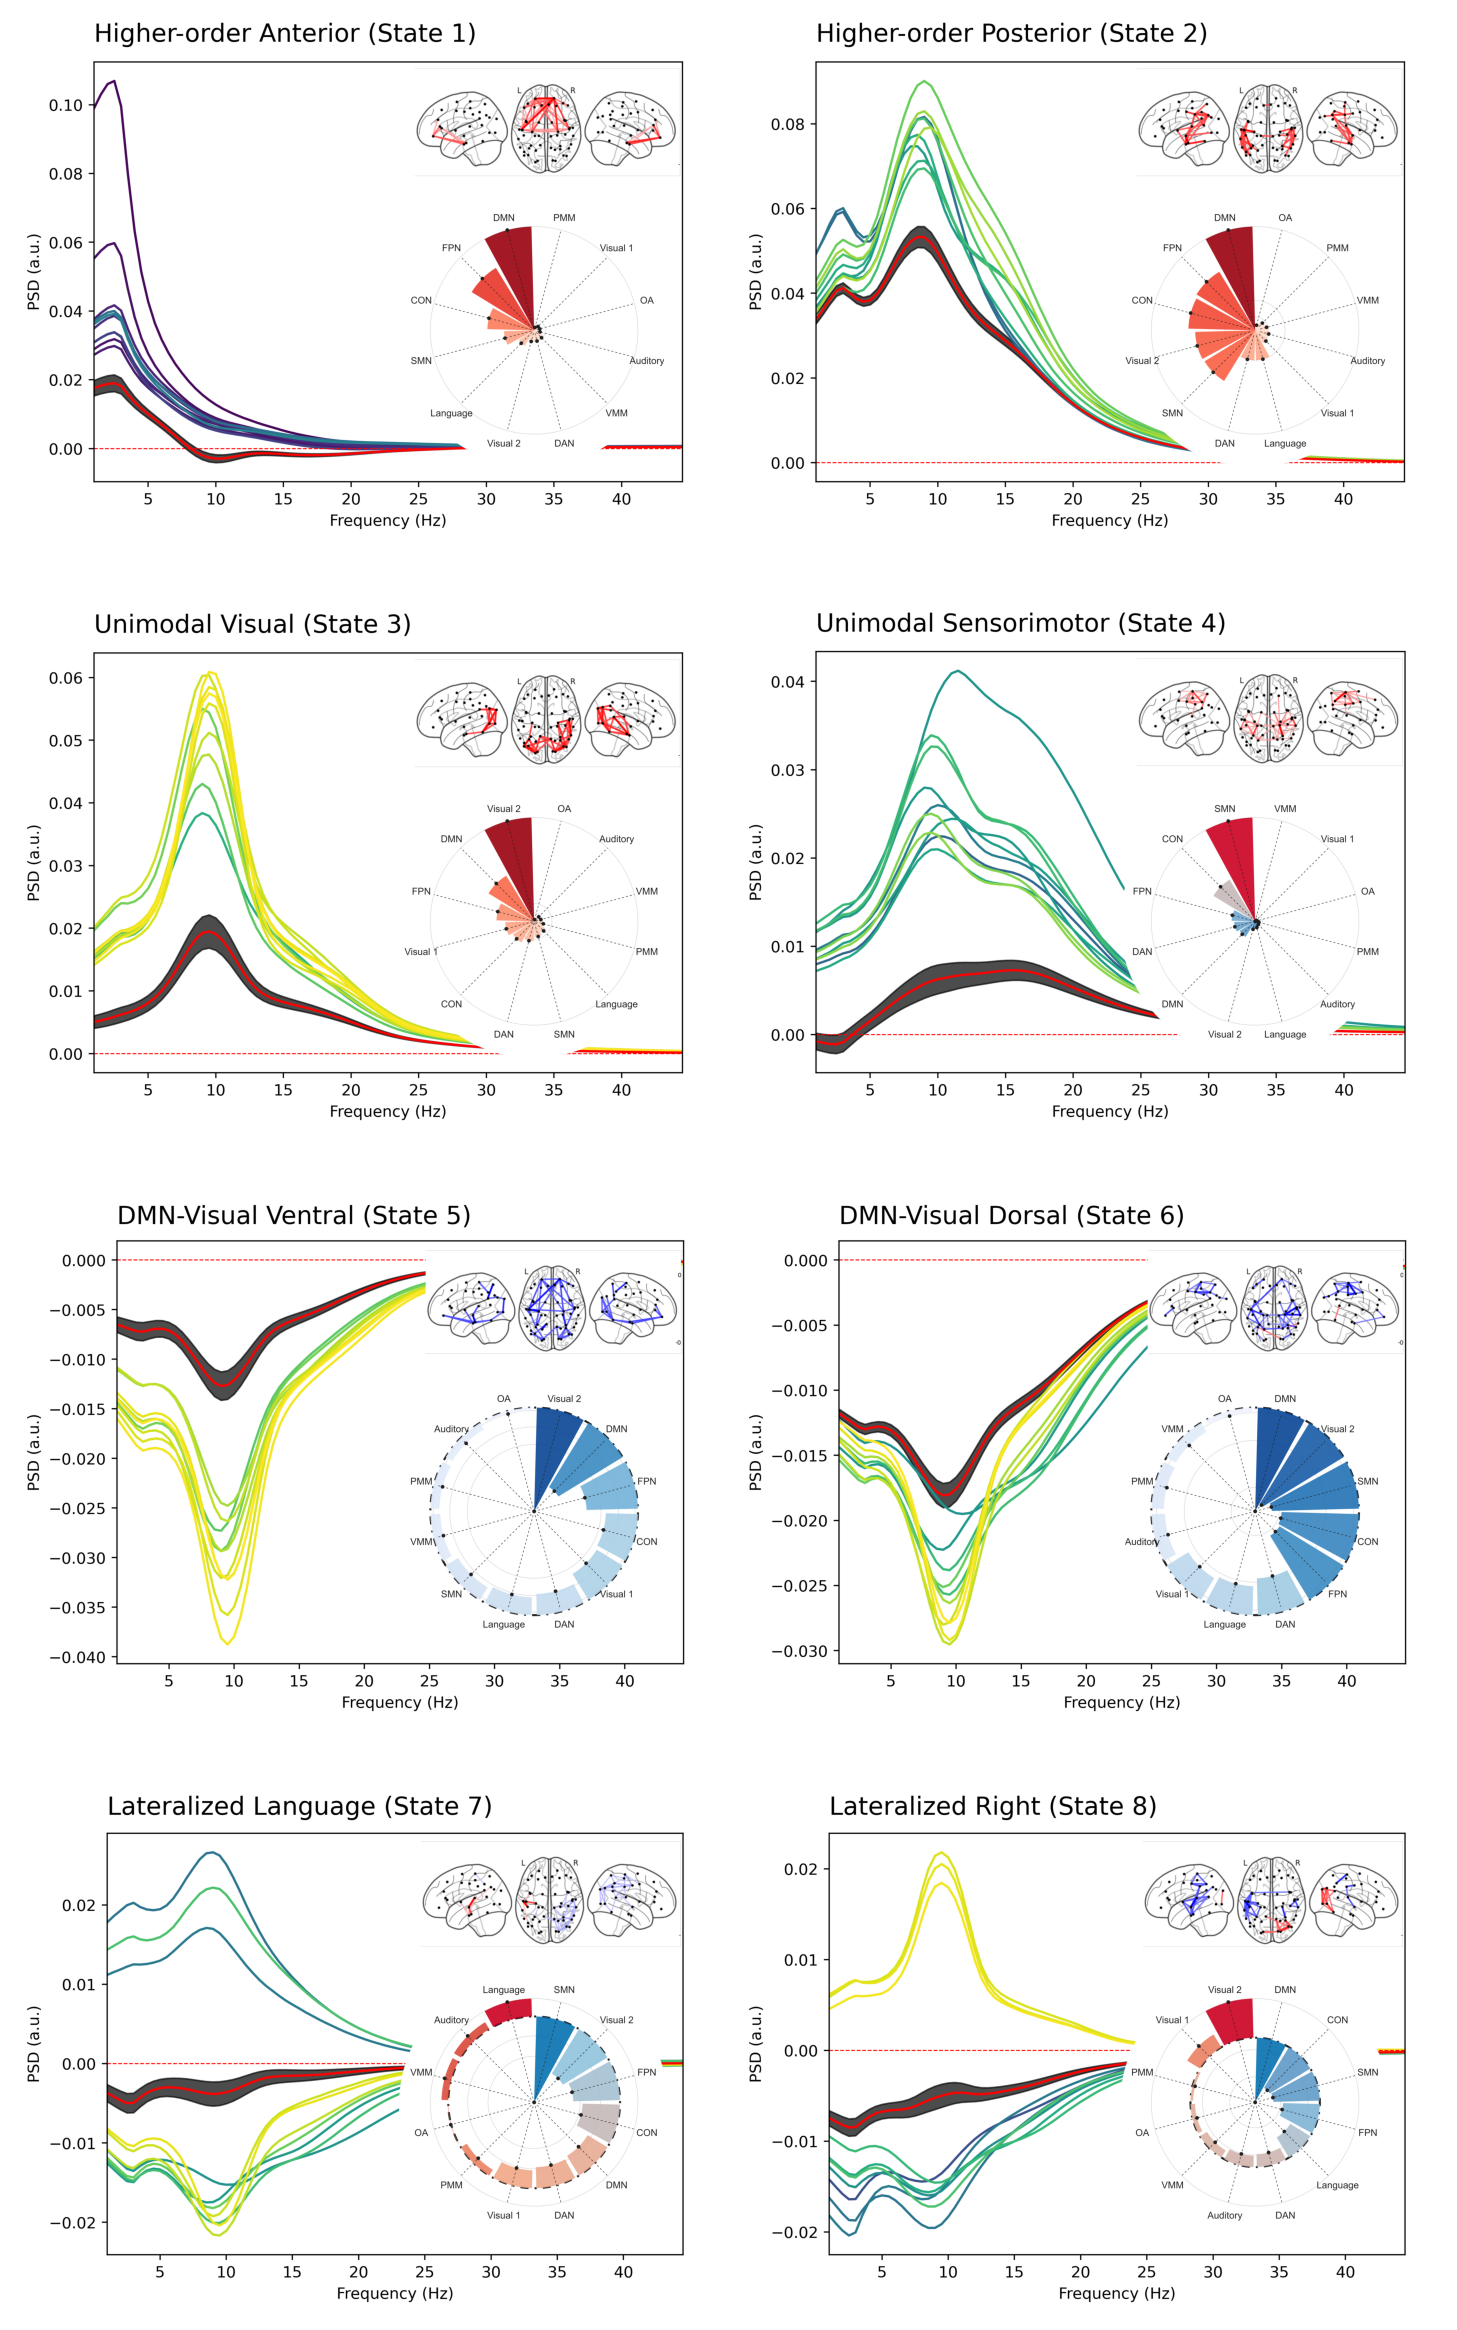

In [40]:
from osl_dynamics.utils.plotting import plot_markers
from osl_dynamics.utils.plotting import plot_psd_topo
from osl_dynamics.utils.parcellation import Parcellation
import matplotlib.colors
from matplotlib.image import imread
nparcels = 10

# Re-order to use colour to indicate anterior->posterior location
parcellation = Parcellation(parcellation_file)
roi_centers = parcellation.roi_centers()
order = np.argsort(roi_centers[:, 1]) # Anterior-to-Posterior reordering of the parcels

gpsd_mean_reordered = gpsd_mean[:,order,:]
idx_parcels_reordered = np.argsort(np.abs(pow_state_all[:,order]))
np.save(f"{networks_dir}/idx_parcels_mni_reordered.npy", idx_parcels_reordered)

fig, axs = plt.subplots(4, 2, figsize=(30, 30))
plt.subplots_adjust(wspace=-0.55, hspace=0.1)

for state, ax_subplot in enumerate(axs.flat):
    #################################################################################
    # Main plot
    #################################################################################
    fig, ax = plot_psd_topo(f,gpsd_mean_reordered[state,...],
                only_show=idx_parcels_reordered[state,-nparcels:], # Plot the 10 highest only
                    ) # type: ignore
    ax.axhline(y = 0, color = 'r', linestyle = '--', linewidth = 2/3) # type: ignore
    ax.set_title(f"{brain_states_dict[state+1]} (State {state+1})", loc='left', fontsize = 16) # type: ignore

    saliency_mean = np.mean(gpsd_mean_reordered[state,:],axis=-2)
    saliency_sem = np.std(gpsd_mean_reordered[state,:],axis=-2) / np.sqrt(52)
    ax.fill_between(f, saliency_mean-saliency_sem, saliency_mean+saliency_sem, color='black', alpha=0.7) # type: ignore
    ax.plot(f, saliency_mean, color='r') # type: ignore

    # State-relevant frequency band ##############################################
    # inside_ax = ax.inset_axes([0.74, 0.02, 0.25, 0.25]) # type: ignore
    # plotting.plot_line(
    #     [f],  # we need to repeat f times because we fitted f components
    #     [weights_freqranges[state,:]],
    #     ax=inside_ax,
    #     plot_kwargs={"color": "black",
    #                  "linestyle": "dashdot"}
    # )  # type: ignore
    # plt.suptitle("Relevant\n frequency\n band", fontsize = 9, x = 0.91, y = 0.28)
    # inside_ax.set_xticks(np.arange(0,60,15))
    # inside_ax.tick_params(left = False, labelleft = False,
    #                       bottom = False, labelbottom = False,
    #                       labelsize = 7, length=3)
    # inside_ax.fill_between(f,weights_freqranges[state,:], alpha = .8, color = "grey")

    # Topoplot ##############################################
    # display_nparcels = 20
    # if state == 4:
    #     plot_markers(
    #             np.arange(display_nparcels),
    #             roi_centers[idx_parcels[state,-(display_nparcels):]], # ordered by state-relevant parcels
    #             node_cmap= matplotlib.colors.LinearSegmentedColormap.from_list(
    #                 'custom_cmap',
    #                 plt.cm.viridis_r(np.linspace(0, 1, 52))[idx_parcels_reordered[state,-(display_nparcels):]]
    #                 ),
    #             node_size=12, # type: ignore
    #             colorbar=False,
    #             display_mode='lzr',
    #             axes=ax.inset_axes([0.58, 0.52, 0.40, 0.45]), # type: ignore
    #         )
    # elif state == 5:
    #     plot_markers(
    #             np.arange(display_nparcels),
    #             roi_centers[idx_parcels[state,-(display_nparcels):]], # ordered by state-relevant parcels
    #             node_cmap= matplotlib.colors.LinearSegmentedColormap.from_list(
    #                 'custom_cmap',
    #                 plt.cm.viridis_r(np.linspace(0, 1, 52))[idx_parcels_reordered[state,-(display_nparcels):]]
    #                 ),
    #             node_size=12, # type: ignore
    #             colorbar=False,
    #             display_mode='lzr',
    #             axes=ax.inset_axes([0.58, 0.5, 0.40, 0.45]), # type: ignore
    #         )
    # else:
    #     plot_markers(
    #             np.arange(display_nparcels),
    #             roi_centers[idx_parcels[state,-(display_nparcels):]], # ordered by state-relevant parcels
    #             node_cmap= matplotlib.colors.LinearSegmentedColormap.from_list(
    #                 'custom_cmap',
    #                 plt.cm.viridis_r(np.linspace(0, 1, 52))[idx_parcels_reordered[state,-(display_nparcels):]]
    #                 ),
    #             node_size=12, # type: ignore
    #             colorbar=False,
    #             display_mode='lzr',
    #             axes=ax.inset_axes([0.58, 0.58, 0.40, 0.45]), # type: ignore
    #         )
        
    # Connectivity plots #######################################################
    coh_path = f"{networks_dir}/coh_state_{state}.png"
    img_power_map = imread(coh_path, format="png")
    # Create a rectangular mask to crop the bottom part
    mask = np.ones_like(img_power_map)
    mask[:40, :] = 0
    mask[-70:, :] = 0
    mask[:, -65:] = 0
    cropped_image = img_power_map * mask

    inside_ax_subplot2 = ax.inset_axes([0.545, 0.59, 0.5, 0.5]) # type: ignore
    inside_ax_subplot2.imshow(cropped_image)
    inside_ax_subplot2.axis('off')

    # Save individual state before embedding in subplots #############################
    plt.tight_layout()
    psd_img_path = f"{networks_dir}/psd_state_{state+1}.png"
    plt.savefig(psd_img_path, dpi = 400)
    plt.close()

    #################################################################################
    # Subplot Embedding
    #################################################################################
    png_path = f"{networks_dir}/psd_state_{state+1}.png"
    main_img = imread(png_path, format="png")
    # Display the image in the subplot
    ax_subplot.imshow(main_img)
    ax_subplot.axis('off')

    # RSN composition #########################################################
    img = imread(f"{networks_dir}/State_{state+1}_RSN_composition.png")

    mask = np.ones_like(img[..., 0])
    center = np.array(img.shape[:2]) / 2
    radius = min(img.shape[:2]) / 2
    y, x = np.ogrid[:img.shape[0], :img.shape[1]]
    circle = ((x - center[1]) ** 2 + (y - center[0]) ** 2 > radius ** 2)
    mask[circle] = 0 # Setting anything outside the mask to transparent
    cropped_image = np.dstack((img, mask))
    
    inside_ax_subplot = ax_subplot.inset_axes([0.48, 0.15, 0.5, 0.5])
    inside_ax_subplot.imshow(cropped_image)
    inside_ax_subplot.axis('off')

    # Spatial power maps #######################################################
    # png_path = f"{networks_dir}/pow{state}.png"
    # img_power_map = imread(png_path, format="png")
    # # Create a rectangular mask to crop the bottom part
    # mask = np.ones_like(img_power_map)
    # mask[-150:, :] = 0 
    # cropped_image = img_power_map * mask

    # inside_ax_subplot2 = ax_subplot.inset_axes([0.655, 0.82, 0.3, 0.3])
    # inside_ax_subplot2.imshow(cropped_image)
    # inside_ax_subplot2.axis('off')
    
plt.savefig(f"{networks_dir}/Figure_1.png")

With all channels averaged

In [ ]:
gpsd_static_channels = np.mean(gpsd_static, axis=-2) # Mean across channels
gpsd_static_channels_err = np.std(gpsd_static, axis=-2) / np.sqrt(gpsd_static.shape[-2]) # standard error

gpsd_mean_channels = np.mean(gpsd_mean, axis=-2) # Mean across channels
gpsd_mean_channels_err = np.std(gpsd_mean, axis=-2) / np.sqrt(gpsd_mean.shape[-2]) # standard error

# Plot static
fig, ax = plotting.plot_line(
    [f],
    [gpsd_static_channels],
    errors=[
        [gpsd_static_channels - gpsd_static_channels_err], 
        [gpsd_static_channels + gpsd_static_channels_err]
    ],
    labels=["Static"],
    x_label="Frequency (Hz)",
    y_label="PSD (a.u.)",
    title="Static PSD"
) # type: ignore

fig.savefig(f"{networks_dir}/psd_static.png")

import seaborn as sns
colors = sns.color_palette('colorblind')

# Plot dynamic
fig, ax = plotting.plot_line(
    [f] * 8,
    gpsd_mean_channels,
    errors=[
        gpsd_mean_channels - gpsd_mean_channels_err, 
        gpsd_mean_channels + gpsd_mean_channels_err
        ],
    labels=[f"State {i + 1}" for i in range(8)],
    x_label="Frequency (Hz)",
    y_label="PSD (a.u.)",
    title="Dynamic State PSDs"
) # type: ignore

fig.savefig(f"{networks_dir}/psd_dynamic.png")